In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from functools import cached_property

# Option Portfolio

Analytical formulae for calls & puts:
\begin{align*}
C_0 & = \mathbb{E}[e^{-rT}(S_T-K)^+] \\
    & = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2) \\\\    
P_0 & = \mathbb{E}[e^{-rT}(K-S_T)^+] \\
    & = Ke^{-rT}\Phi(-d_2)-S_0\Phi(-d_1)
\end{align*}
Where:
\begin{align*}
d_1 & = \frac{\log(\frac{S_0}{K}) + (r + 0.5 \sigma^2)T }{\sigma \sqrt{T}}, \\
d_2 & = d_1 - \sigma \sqrt{T}.  
\end{align*}

In [2]:
def calculate_d1_d2(s0, k, T, r, sigma):
  d1 = (np.log(s0 / k) + (r + 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  return d1, d2

class Option:
  def __init__(self, name, price, payoff):
    self.name = name
    self.price = price
    self.payoff = payoff

def call_price(s0, k, T, r, sigma):
  d1, d2 = calculate_d1_d2(s0, k, T, r, sigma)
  return s0 * norm.cdf(d1) - k * np.exp(-r * T) * norm.cdf(d2)
def call_payoff(sT, k):
  return np.maximum(sT - k, 0)

def put_price(s0, k, T, r, sigma):
  d1, d2 = calculate_d1_d2(s0, k, T, r, sigma)
  return k * np.exp(-r * T) * norm.cdf(-d2) - s0 * norm.cdf(-d1)
def put_payoff(sT, k):
  return np.maximum(k - sT, 0)

In [3]:
class Portfolio:
    def __init__(self, *positions):
      self.positions = positions

    def describe(self):
      """Print strategy details."""
      for option, strike, qty in self.positions:
          action = "Buy" if qty > 0 else "Sell"
          print(f"  {action} {abs(qty)} {option.name} at K={strike}")

    def payoff(self, sT : np.ndarray):
      return sum(qty * option.payoff(sT, strike) for option, strike, qty in self.positions)

    def analytical_price(self, s0, t, r, sigma):
      return sum(qty * option.price(s0, strike, t, r, sigma) for option, strike, qty in self.positions)

    def get_payoff_graph(self, stock_range=(50, 150), ax = None):
      """Plots the payoff diagram for the strategy."""
      if ax is None:
        fig, ax = plt.subplots()
      else:
        fig = ax.figure

      stock_prices = np.linspace(stock_range[0], stock_range[1], 200)
      payoffs = self.payoff(stock_prices)

      ax.plot(stock_prices, payoffs, label="Strategy Payoff", color='b', linewidth=2)

      # Breakeven line
      ax.axhline(0, color='black', linewidth=1, linestyle='--')

      # First strike price
      ax.axvline(x=self.positions[0][1], color='gray', linestyle='--', alpha=0.6)

      ax.set_xlabel("Stock Price at Expiration")
      ax.set_ylabel("Profit / Loss")
      ax.set_title("Option Strategy Payoff Diagram")
      ax.grid(True)
      return fig

    def graph_payoff(self):
      fig = self.get_payoff_graph()
      fig.show()

Example option strategies:

In [4]:
Call = Option("Call", call_price, call_payoff)
Put = Option("Put", put_price, put_payoff)

bull_call_spread = Portfolio(
    (Call, 100, +1),
    (Call, 110, -1)
)

iron_condor = Portfolio(
    (Put, 90, +1),
    (Put, 95, -1),
    (Call, 105, -1),
    (Call, 110, +1)
)

straddle = Portfolio(
    (Call, 100, +1),
    (Put, 100, +1)
)

# bull_call_spread.graph_payoff()
# iron_condor.graph_payoff()
# straddle.graph_payoff()

# Asset Simulator

Terminal price of an asset:
\begin{align*}
S_T & = S_0 e^{(r - 0.5 \sigma^2)T + \sigma W_T}
\end{align*}

In [5]:
class AssetSimulator():
    def __init__(self, rng, s0, t, r, sigma, simulation_n):
        """Simulates terminal asset price n times"""
        self.rng = rng
        self.s0 = s0
        self.t = t
        self.r = r
        self.sigma = sigma
        self.simulation_n = simulation_n

    @property
    def discount(self):
        """Discount under constant interest r"""
        return np.exp(-self.r * self.t)

    @cached_property
    def sT(self) -> np.ndarray:
        """Terminal stockprice sT"""
        tmp1 = (self.r - 0.5*(self.sigma ** 2)) * self.t
        tmp2 = self.sigma * np.sqrt(self.t) * self.rng.standard_normal(size=self.simulation_n)
        return self.s0 * np.exp(tmp1 + tmp2)

    @cached_property
    def discounted_sT(self) -> np.ndarray:
        return np.exp(-self.r * self.t) * self.sT

    def get_hist(self, ax = None):
      """Creates histogram of sT"""
      if ax is None:
        fig, ax = plt.subplots()
      else:
        fig = ax.figure

      ax.hist(self.sT, bins=100)
      ax.set_ylabel("Frequency")
      ax.set_xlabel("$S_T$")
      ax.set_title("Histogram of simulated $S_T$")
      return fig

    def display_hist(self):
      fig = self.get_hist()
      fig.show()

# Option Simulator

Value at Risk & Expected Shortfall:
$$\mathbb{P}[L_H < \text{VaR}_{H,\alpha}] = \alpha$$
\begin{align*}
\text{ES}_{H,\alpha} & = \mathbb{E}^\mathbb{P}[L_H|L_H > \text{VaR}_{H,\alpha}] \\
                 & = \frac{\mathbb{E}^\mathbb{P}[L_H1_{\{L_H > \text{VaR}_{H,\alpha}\}}]}{1-\alpha}
\end{align*}
Where:
$$L_H = \text{Portfolio}_0 - \text{Portfolio}_H$$

To estimate $\mathbb{E}[X]$, we can use the control variate estimator. \\
Given a $Y$ such that $\mathbb{E}[Y]$ is known:
$$
\bar{X}_n=\frac{1}{n}\sum_{i=1}^n(X_i+ c^*(Y_i-\mathbb{E}[Y])),
\quad \textrm{with} \quad c^*=-\frac{\operatorname{cov}(X,Y)}{\operatorname{var}(Y)}.
$$

In [6]:
class OptionSimulator():
    def __init__(self, asset : AssetSimulator, portfolio : Portfolio):
      """Calculates various properties of a portfolio"""
      self.asset = asset
      self.portfolio = portfolio

    @cached_property
    def discounted_payoff(self) -> np.ndarray:
      return self.asset.discount * self.portfolio.payoff(self.asset.sT)

    @cached_property
    def z(self) -> np.ndarray:
      """Control variate simulation: each z_i is an estimator for the option price"""
      cstar = -np.cov(self.discounted_payoff,
                      self.asset.discounted_sT,
                      ddof=1)[0, 1] / np.var(self.asset.discounted_sT, ddof=1)
      z = self.discounted_payoff + cstar * (self.asset.discounted_sT - self.asset.s0)
      return z

    @cached_property
    def eZ(self) -> float:
      """E[z]"""
      return np.mean(self.z)

    @cached_property
    def varZ(self) -> float:
      """Var[z]"""
      return np.var(self.z)

    @cached_property
    def LH(self) -> np.ndarray:
      """Loss over time horizon: difference between portfolio value at time 0 and time T"""
      portfolio_0 = self.portfolio.analytical_price(
          self.asset.s0, self.asset.t, self.asset.r, self.asset.sigma
      )
      portfolio_T = self.portfolio.analytical_price(
          self.asset.sT, self.asset.t, self.asset.r, self.asset.sigma
      )
      return portfolio_0 - portfolio_T

    @property
    def rhosquared(self) -> float:
      """Squared correlation between discounted payoff and discounted stock"""
      cov = np.cov(self.asset.discounted_sT, self.discounted_payoff, ddof=1)[0, 1]
      varx = np.var(self.discounted_payoff, ddof=1)
      vary = np.var(self.asset.discounted_sT, ddof=1)
      rhosquared = (cov ** 2) / (varx * vary)
      return rhosquared

    def CI(self, epsilon = 0.05) -> tuple:
      """Confidence interval with SL epsilon"""
      sigma_est = self.eZ / np.sqrt(self.asset.simulation_n)
      aepsilon = norm.ppf(1.0 - epsilon * 0.5)

      # Left and right boundaries of CI
      ci_left = self.eZ - aepsilon * sigma_est
      ci_right = self.eZ + aepsilon * sigma_est

      return ci_left, ci_right

    def VaR(self, alpha = .95) -> float:
      # LH is negative so percentile is 1 - alpha
      return np.percentile(self.LH, (1 - alpha) * 100)

    def ES(self, alpha = .95) -> float:
      # LH is negative so condition is LH <= VaR
      return np.mean(self.LH * (self.LH <= self.VaR(alpha))) / (1 - alpha)

    def summarise(self, dp = 5):
      """Prints details of the simulation."""
      print("Analytical price: {}".format(
          self.portfolio.analytical_price(
              self.asset.s0, self.asset.t, self.asset.r, self.asset.sigma
              )
          ))
      print(f"Monte Carlo price: {round(self.eZ, dp)}, sigma: {round(self.varZ, dp)}")
      print("CI: ({:.2f}, {:.2f}).".format(*self.CI()))
      print(f"VaR: {round(self.VaR(), dp)}, ES: {round(self.ES(), dp)}")
      print(f"Rhosquared: {round(self.rhosquared, dp)}")

    def get_pnl_hist(self, alpha = 0.95, ax = None):
        """Returns a histogram figure of P&L with VaR and ES marked."""
        if ax is None:
          fig, ax = plt.subplots()
        else:
          fig = ax.figure

        ax.hist(self.LH, bins=50, alpha=0.75, color='blue')
        ax.set_ylabel("Frequency")
        ax.set_xlabel("$L_H$")
        ax.set_title("Histogram of $L_H$")

        # VaR and ES lines
        var_value = self.VaR(alpha)
        es_value = self.ES(alpha)
        ax.axvline(x=var_value, color='r', linestyle='--', label=f'VaR ({var_value:.2f})')
        ax.axvline(x=es_value, color='b', linestyle='--', label=f'ES ({es_value:.2f})')

        ax.legend()

        return fig

    def display_pnl(self):
      fig = self.get_pnl_hist()
      plt.show()

    def display_graphs(self):
      """Displays 3 Graphs: Portfolio, Simulated Stocks and P&L Graphs"""
      fig, axes = plt.subplots(1, 3, figsize=(15, 4))
      self.portfolio.get_payoff_graph(ax=axes[0])
      self.asset.get_hist(ax=axes[1])
      self.get_pnl_hist(ax=axes[2])
      fig.show()


# Single Simulation

In [7]:
rng = np.random.default_rng(12345)
S0 = 100.0
T = 0.25
R = 0.05
Sigma = 0.3
Samplesize = 10000
Epsilon = 0.05

Plot asset's terminal stock price.

Compare analytical results with monte-carlo results.

Plot loss over time horizon of the strategy.

Analytical price: 11.923949045373085
Monte Carlo price: 11.89991, sigma: 81.75312
CI: (11.67, 12.13).
VaR: -19.12773, ES: -26.81064
Rhosquared: 0.08504


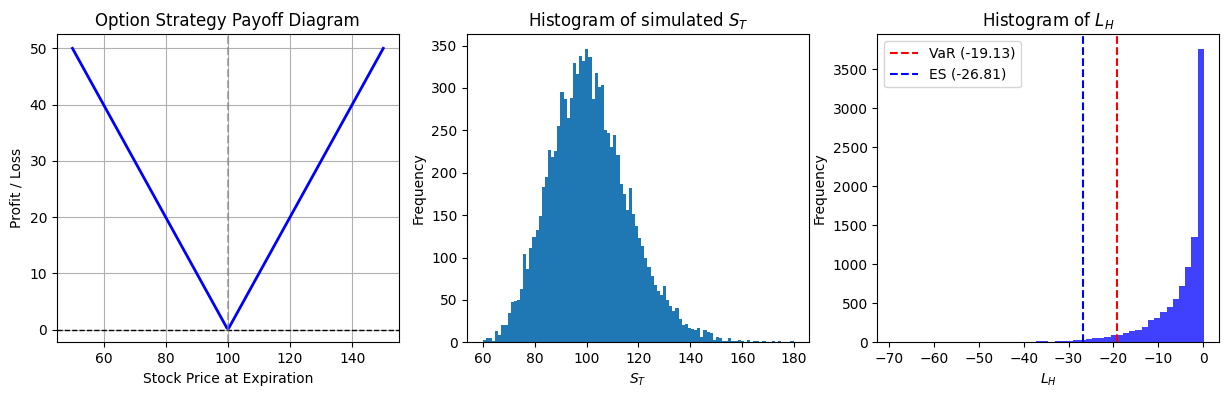

In [8]:
assetSimulator = AssetSimulator(rng, S0, T, R, Sigma, Samplesize)

sim = OptionSimulator(assetSimulator, straddle)
sim.display_graphs()
sim.summarise()

# Differing Interest Rates

OptionSimulator can monitor how VaR and ES shifts with interest rate.

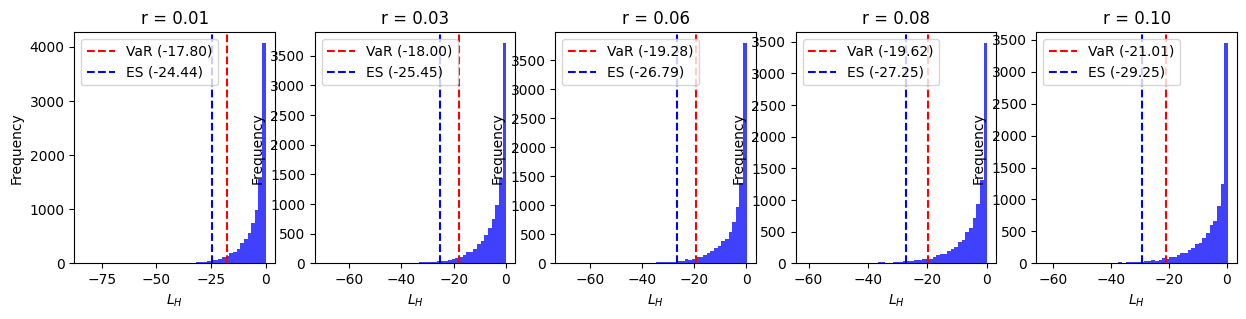

In [9]:
def generateAssetSimulations(lower, upper, n):
  return [AssetSimulator(rng, S0, T, r, Sigma, Samplesize)
          for r in np.linspace(lower, upper, n)]

def generateOptionSimulations(assetSimulations, option):
  return [OptionSimulator(asset, option) for asset in assetSimulations]

n = 5
asset_sims = generateAssetSimulations(0.01, 0.1, n)
option_sims = generateOptionSimulations(asset_sims, straddle)

fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
for i, sim in enumerate(option_sims):
  sim.get_pnl_hist(ax=axes[i])
  axes[i].set_title(f'r = {sim.asset.r:.2f}')
fig.show()

# Vasicek Model

Perhaps more interestingly, we can observe how these risk measures may vary with respect to other interest-related parameters, like volatility in interest. Instead of modelling $r$ as a constant, we can model short term interest rates stochastically using the Vasicek model.

Under the Vasicek model:

\begin{align*}
dr_t & = k(\theta-r_t)dt+\sigma_2 dW^{(1)}_t \\
dS_t & = r_tS_tdt+\sigma_1S_tdW^{(2)}_t
\end{align*}

To construct two correlated weiner samples $dW^{(1)}_t$ and $dW^{(2)}_t$, we apply a Cholevsky decomposition to the correlation matrix $\begin{bmatrix}
dt & \rho \cdot dt \\
\rho \cdot dt & dt
\end{bmatrix}$ to yield the transformation
\begin{align*}
dW^{(1)}_t &= dW_{t,1} \\
dW^{(2)}_t &= \rho \cdot dW_{t,1} + \sqrt{1 - \rho^2} \cdot dW_{t,2}
\end{align*}

We can solve for $r_t$ explicitly since it is an Ornstein-Uhlenbeck process:
\begin{align*}
\mu & = r_0 e^{-kt} + \theta (1 - e^{-kt}) \\
\sigma & = \sqrt{\frac{\sigma^2}{2k} (1 - e^{-2kt})}
\end{align*}

https://onlinelibrary.wiley.com/doi/10.1155/2018/7056734


In [21]:
class InterestSimulator():
  def __init__(self, rng, r0, t, k, theta, sigma, simulation_n, dt):
    self.rng = rng
    self.r0 = r0
    self.t = t
    self.k = k
    self.theta = theta
    self.sigma = sigma
    self.simulation_n = simulation_n
    self.dt = dt

  @property
  def steps(self) -> int:
    return int(np.floor(self.t / self.dt))

  @cached_property
  def wI_std_normal(self) -> np.ndarray:
    return self.rng.standard_normal((self.simulation_n, self.steps - 1))

  @cached_property
  def rT(self) -> np.ndarray:
    steps = self.steps
    rT = np.full((self.simulation_n, steps), self.r0)
    for step in range(1, steps):
        drT = self.k * (self.theta - rT[:, step - 1]) * self.dt + self.sigma * self.wI_std_normal[:, step - 1]
        rT[:, step] = rT[:, step - 1] + drT
    return rT

  def rT_sol_parameters(self, t):
    """
    Distribution of interest rate after time t
    NOTE: Not too useful since W between interest rate and asset are not independent
    """
    mu = self.r0 * np.exp(-self.k * t) + self.theta * (1 - np.exp(-self.k * t))
    sigma = np.sqrt((self.sigma ** 2 / (2 * self.k)) * (1 - np.exp(-2 * self.k * t)))
    return mu, sigma


In [25]:
class AssetInterestSimulator(AssetSimulator):
    def __init__(self, interest, rho, s0, r0, sigma):
        self.interest = interest
        self.rho = rho
        super().__init__(
            rng=interest.rng,
            s0=s0,
            t=interest.t,
            r=r0,
            sigma=sigma,
            simulation_n=interest.simulation_n
        )

    @cached_property
    def sT(self) -> np.ndarray:
        """Simulates the asset price with correlated Wiener process."""
        steps = self.interest.steps
        sT = np.full((self.simulation_n, steps), self.s0)
        for step in range(1, steps):
            # Correlated dW: dW_asset = rho * dW_interest + sqrt(1 - rho^2) * dW_independent
            dW_interest = self.interest.wI_std_normal[:, step - 1]
            dW_independent = self.rng.standard_normal(self.simulation_n)
            dW_asset = self.rho * dW_interest + np.sqrt(1 - self.rho**2) * dW_independent

            # Update S_t using GBM with stochastic drift r_t
            drift = self.interest.rT[:, step - 1] * sT[:, step - 1] * self.interest.dt
            diffusion = self.sigma * sT[:, step - 1] * dW_asset
            sT[:, step] = sT[:, step - 1] + drift + diffusion
        return sT

    @cached_property
    def discounted_sT(self) -> np.ndarray:
        """Discounts the asset price using the integrated interest rate."""
        # Approximate the integral of r_t over [0, T] using trapezoidal rule
        integral_r = np.trapz(self.interest.rT, axis=1)
        discount_factor = np.exp(-integral_r)
        return discount_factor[:, np.newaxis] * self.sT

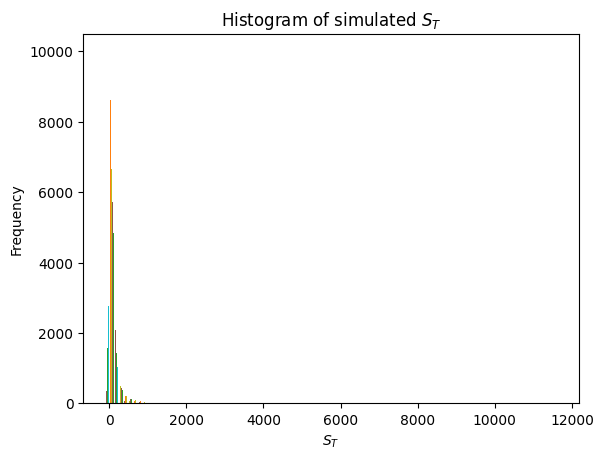

In [27]:
Theta = 0.02
Rho = 0.5
InterestSigma = 0.05
K = 0.1

interestSimulator = InterestSimulator(rng, R, T, K, Theta, InterestSigma, Samplesize, 0.01)
assetInterestSimulator = AssetInterestSimulator(interestSimulator, Rho, S0, R, Sigma)

fig = assetInterestSimulator.get_hist()
plt.show()